<a href="https://colab.research.google.com/github/nowshad7/CSE4100and4250/blob/main/Ext_Summ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#import rouge
from yellowbrick.cluster import KElbowVisualizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Ex_Summ/Data/entertainment

/content/drive/My Drive/Ex_Summ/Data/entertainment


In [ ]:
filename=input("Enter File Name: ")  
news = open(filename,"r")
text = news.read()

Enter File Name: 006.txt


In [ ]:
sentences = nltk.sent_tokenize(text)
sentences

["Bennett play takes theatre prizes\n\nThe History Boys by Alan Bennett has been named best new play in the Critics' Circle Theatre Awards.",
 'Set in a grammar school, the play also earned a best actor prize for star Richard Griffiths as teacher Hector.',
 "The Producers was named best musical, Victoria Hamilton was best actress for Suddenly Last Summer and Festen's Rufus Norris was named best director.",
 "The History Boys also won the best new comedy title at the Theatregoers' Choice Awards.",
 "Partly based upon Alan Bennett's experience as a teacher, The History Boys has been at London's National Theatre since last May.",
 "The Critics' Circle named Rebecca Lenkiewicz its most promising playwright for The Night Season, and Eddie Redmayne most promising newcomer for The Goat or, Who is Sylvia?",
 'Paul Rhys was its best Shakespearean performer for Measure for Measure at the National Theatre and Christopher Oram won the design award for Suddenly Last Summer.',
 "Both the Critics' Ci

In [ ]:
art_size = len(sentences)
print(art_size)

10


#BERT Word  Embedinnings

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import logging
import matplotlib.pyplot as plt
% matplotlib inline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
def BERT_emb(sentence):
  marked_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]
  token_vecs = hidden_states[-2][0]
  sentence_embedding = torch.mean(token_vecs, dim=0)
  return sentence_embedding.numpy()

In [ ]:
text = "Gallery unveils interactive tree."
emb = BERT_emb(text)
emb[0]

-0.1361416

In [ ]:
print ("Our final sentence embedding vector of shape:", len(emb))

Our final sentence embedding vector of shape: 768


In [ ]:
emb_Matrix = []
for sentence in sentences:
  emb = BERT_emb(sentence)
  emb_Matrix.append(emb)
print(len(emb_Matrix[0]))
print(len(emb_Matrix))

768
13


#Visualization

In [ ]:
from scipy.spatial.distance import pdist,squareform
array_similarity = squareform(pdist(emb_Matrix, metric='euclidean'))

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

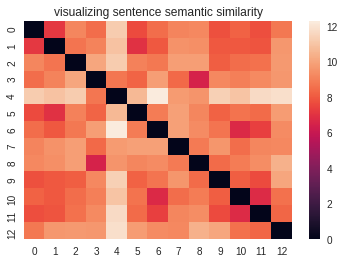

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')

In [ ]:
plt.savefig('/content/drive/My Drive/Ex_Summ/Data/ss02.png')

<Figure size 432x288 with 0 Axes>

#K-Means Clustering

In [ ]:
emb_sentences = pd.DataFrame(emb_Matrix)

In [ ]:
emb_sentences.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.092861,0.289360,0.529459,-0.272351,0.105511,-0.630268,0.082774,0.612766,-0.140225,0.170771,-0.004883,-0.408938,0.206396,0.240189,-0.121436,1.028580,0.243332,-0.176516,-0.501673,-0.015150,-0.412800,-0.040987,0.131995,0.403863,0.714378,0.230311,0.161532,0.323962,-0.462656,0.487841,0.043712,0.518551,0.186840,-0.325530,-0.355085,-0.255101,0.195814,-0.290515,0.486760,0.077024,...,-0.424800,-0.076060,0.372504,-0.506828,-0.319484,0.089474,0.284814,-0.247889,0.342928,0.033031,0.093457,0.178902,0.181042,-0.137303,0.137516,0.155810,0.253445,0.288979,-0.471299,-0.240966,-0.102444,0.538173,0.341834,-0.217870,0.449427,0.115187,-0.289077,0.412160,-0.270912,-0.637938,0.417861,-0.028469,-0.126023,0.239379,0.272736,0.054738,-0.206083,0.204702,-0.090258,-0.289373
1,-0.238248,-0.202231,0.760221,-0.426236,-0.194365,-0.926546,0.274211,0.493683,-0.439362,0.341577,-0.648607,-0.792832,0.074713,0.610636,-0.343662,0.347152,-0.002706,0.291262,0.001180,0.018902,-0.182146,-0.159217,0.479411,0.376630,0.513610,-0.308210,0.096486,0.359489,-0.373040,0.236963,0.010077,-0.117762,-0.073242,0.012282,-0.269568,-0.298970,0.260460,-0.155984,-0.029242,-0.129993,...,-0.381440,-0.422670,0.198396,0.163002,-0.814387,0.006043,0.723452,0.074904,-0.234093,-0.033742,-0.079099,0.162796,0.286926,-0.202724,-0.158867,-0.034181,0.424369,0.233353,-0.653325,-0.558643,-0.030366,0.016592,0.625236,-0.303750,0.606710,-0.167724,0.145429,0.517409,-0.367992,-0.471600,0.277984,0.228676,0.107573,0.114387,0.091323,0.060697,-0.399438,0.192164,0.402463,0.017721
2,0.461877,-0.457880,0.513430,-0.190954,0.109540,-0.551263,-0.045613,0.284407,0.005929,0.096053,-0.464218,-0.268117,-0.122006,-0.065202,0.075796,0.377724,-0.241784,0.106219,0.028569,0.019406,0.021013,0.290803,-0.170949,0.146199,0.292057,-0.034775,0.184371,0.166276,-0.233765,0.031709,-0.032245,0.020250,-0.651930,-0.020060,0.271155,-0.193605,-0.142687,0.033979,0.139530,-0.318093,...,-0.194767,-0.420717,0.386716,0.347061,-0.025488,-0.468410,0.181382,-0.028593,0.270060,0.287085,-0.008730,0.048979,0.145188,0.190702,-0.381874,0.179344,-0.096729,-0.097434,-0.110880,-0.029153,-0.152283,0.503305,0.366973,-0.264216,0.457894,-0.132467,0.183723,0.506543,-0.512732,-0.364811,-0.330962,-0.004874,0.278071,0.163358,-0.366424,-0.070008,-0.426982,-0.199816,-0.055107,-0.419222
3,0.505855,0.506625,0.036616,-0.216881,0.364119,-0.356463,0.117693,0.627619,-0.226438,-0.409549,-0.045220,-0.466911,-0.081473,0.257545,0.075973,0.374480,-0.156698,0.009036,-0.501036,-0.306521,-0.540866,-0.085162,-0.020614,0.384189,0.286379,0.012429,0.037469,0.031580,-0.070766,0.316265,0.304155,0.370369,-0.252221,-0.260843,-0.465615,-0.410219,-0.101935,-0.204209,-0.535378,0.064690,...,-0.360063,-0.092518,-0.160295,-0.314354,-0.039566,-0.293562,0.136468,0.253230,-0.266959,-0.125251,-0.096753,0.030837,-0.182506,-0.247205,-0.107681,0.231200,0.123443,-0.073309,-0.380125,-0.544852,0.136819,0.281157,-0.179868,-0.219408,0.434341,0.204800,0.047569,0.278848,0.030274,-0.343504,0.150335,0.036935,0.051071,-0.117430,0.162060,0.048032,0.110897,-0.118173,0.340653,0.015517
4,-0.060201,0.342230,0.599367,-0.179265,0.220182,0.017627,0.257932,0.607665,-0.264959,-0.658187,0.087819,0.089560,-0.006981,0.212977,-0.060844,0.443026,-0.220228,-0.017828,-0.258729,-0.461075,-0.328743,0.100014,-0.136390,0.863395,0.246413,-0.068395,0.073945,-0.277297,-0.272095,0.300521,0.372591,0.165018,-0.114317,-0.637910,-0.110654,-0.299094,0.153572,-0.129695,-0.078555,0.320768,...,-0.127706,-0.569145,-0.086782,-0.051560,-0.262167,0.117931,-0.360372,0.341504,-0.527174,-0.209345,-0.081836,-0.253879,0.218696,-0.069786,0.245093,0.042547,-0.141536,-0.310480,0.142912,-0.785367,0.225122,0.289814,0.750362,-0.095056,0.162670,-0.185914,-0.249693,-0.167339,-0.16022

#Understanding the Data

In [ ]:
pca = PCA(n_components=2)
pca.fit(emb_sentences)
print(np.sum(pca.explained_variance_ratio_))

0.36799268776845734


In [ ]:
pca_sentence_features = pca.transform(emb_sentences)

Text(0.5, 1.0, '2D PCA projection of embedded sentences from BERT')

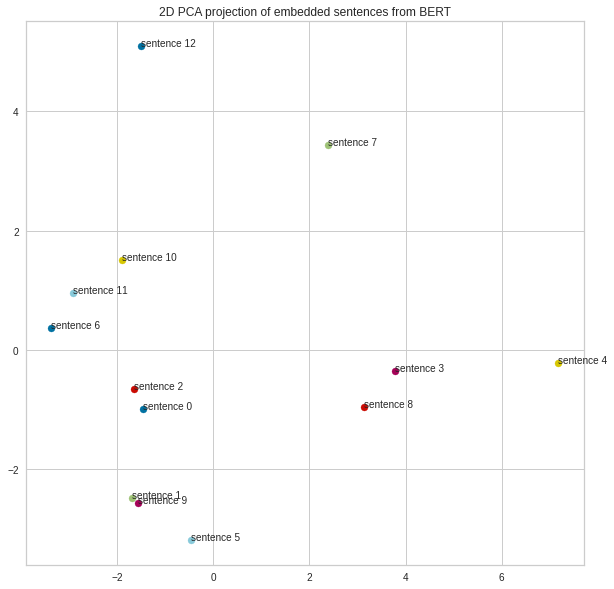

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(pca_sentence_features)):
  plt.scatter(pca_sentence_features[i,0],pca_sentence_features[i,1])
  plt.annotate('sentence '+ str(i),(pca_sentence_features[i,0],pca_sentence_features[i,1]))
plt.title('2D PCA projection of embedded sentences from BERT')

##Elbow Method

In [ ]:
def Elbow_Method(emb_sentences):
  Sum_of_squared_distances = []
  K = range(1,art_size)
  for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(emb_sentences)
    Sum_of_squared_distances.append(km.inertia_)
  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

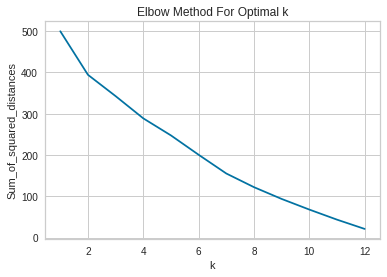

In [ ]:
Elbow_Method(emb_sentences)

##Silhouette Method




In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,art_size)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size).fit(emb_sentences)
    predictions = model.predict(emb_sentences)
    results[size] = silhouette_score(emb_sentences, predictions)

best_size = max(results, key=results.get)
print(best_size)

2


##K-Mean Model

In [ ]:
#num_clusters = 4
def KMean_Clustering(df):
    num_clusters = int(input("Enter Elbow point form graph: "))
    km = KMeans(n_clusters=num_clusters)
    km.fit(df)
    #plt.scatter(emb_sentences, c=km.labels_, cmap='rainbow')
    clusters = km.labels_.tolist()   
    centers = km.cluster_centers_

    return clusters, centers

In [ ]:
clusters, centers = KMean_Clustering(emb_sentences)
print(clusters)
print(centers)

Enter Elbow point form graph: 2
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[[ 0.01128609 -0.15630614  0.48129844 ... -0.04563128  0.12397951
  -0.17796546]
 [ 0.06758066  0.18567331  0.14691817 ... -0.08805837  0.11907012
  -0.06183596]]


In [ ]:
print(emb_Matrix[0])

[-9.28609818e-02  2.89360106e-01  5.29459417e-01 -2.72351414e-01
  1.05510615e-01 -6.30268455e-01  8.27737972e-02  6.12765908e-01
 -1.40225053e-01  1.70770630e-01 -4.88322647e-03 -4.08938050e-01
  2.06396341e-01  2.40189031e-01 -1.21436141e-01  1.02857995e+00
  2.43331879e-01 -1.76516399e-01 -5.01673222e-01 -1.51503980e-02
 -4.12799954e-01 -4.09865081e-02  1.31995410e-01  4.03863072e-01
  7.14378417e-01  2.30311438e-01  1.61531880e-01  3.23962301e-01
 -4.62656230e-01  4.87841159e-01  4.37122062e-02  5.18551350e-01
  1.86840013e-01 -3.25530291e-01 -3.55084717e-01 -2.55101353e-01
  1.95814058e-01 -2.90515333e-01  4.86759841e-01  7.70238712e-02
 -3.70641530e-01 -7.14256644e-01  5.59538364e-01 -2.04401940e-01
 -1.70206636e-01  1.60700589e-01  3.26494366e-01 -9.91554335e-02
  5.48672140e-01 -7.27818534e-03 -5.92033744e-01  8.27579722e-02
 -3.15115064e-01 -3.68329883e-01  2.38659278e-01  2.47024611e-01
 -4.77223247e-01 -3.97144586e-01 -1.93702772e-01  2.24141218e-02
 -5.20030737e-01  2.78253

#Extract Summary

In [ ]:
import math
def ecd_dist(x,y):
  return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [ ]:
idx = []
for center in centers:
  c_dist = []  
  for emb_M in emb_Matrix:
    dist = ecd_dist(center, emb_M)
    print(dist)
    c_dist.append(dist)
  idx.append(c_dist.index(min(c_dist)))
  #print(c_dist)
  print("index = ",c_dist.index(min(c_dist)))
print(idx)

5.272350085969464
5.174767604773056
6.1779923955184985
7.33881403149102
9.899474474969958
5.725611477941063
5.490115507932209
7.587495946425452
7.500142942616446
5.5542235409474925
5.033215685361592
4.854419241270493
6.758768762483736
index =  11
7.953206079528529
8.185667227947635
8.770646360484024
4.354616626449472
6.094755818217766
7.895103636778795
8.923021748121794
5.714802970322887
4.943045618950644
8.141376992162156
7.737731147999281
8.389633942718476
8.859856628571054
index =  3
[11, 3]


In [ ]:
idx.sort()
print(idx)

[3, 11]


In [ ]:
summary = ""
for i in idx:
  summary = summary + sentences[i]

#Summary

In [ ]:
summary

'"Christian Andersen\'s fairy tales are timeless and universal," said Jarre.Later at a gala dinner, Danish supermodel Helena Christensen was named a Hans Christian Andersen ambassador.'